In [7]:
# from pckt import *
path = '~/DAPPEr/data/UDIP4/json/UDIP_4_800s.json'

In [8]:
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

class pck:
    def __init__(self, path, num, sw_type):
        self.path = path
        self.num = num
        self.sw_type = sw_type
        data = pd.read_json(path)
        data = data['packets'][sw_type][f'{self.num}']
        self.data = data
        self.start = data['Start']/1000
        self.stop  = data['Stop']/1000
        self.grnd = data['GroundType']
        self.iv = pd.DataFrame({
                    'V': np.array(self.data['Voltage'][6:]), 
                    'I0': -np.array(self.data['Current0'][6:]) * 10**9, 
                    'I1': -np.array(self.data['Current1'][6:]) * 10**9, 
                    'I2': -np.array(self.data['Current2'][6:]) * 10**9
                    })
    def VP(self):
        self.iv['dI_dV'] = np.abs(self.iv['I0'].diff())
        ind = self.iv['dI_dV'].argmax()
        return self.iv['V'][ind]
    def Vf(self):
        sign = np.where((np.diff(np.sign(self.iv['I0'])) !=0))[0]
        low = np.argmin(np.abs(self.iv['V'][sign]))
        Vf = self.iv['V'][sign[low]]
        return Vf

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import optimize

# #fitting and helper functions

# def gen_fit(x_raw,y_raw):
#     x,y = data_processing(x_raw,y_raw)
#     # x,y = x_raw, y_raw
#     g = [2, 2, -14, 80, 5*(10**10), 700 ]    #intial guess
#     b = [
#         (-3,   2, -1000, -1000, 0     , 0    ),
#         ( 3,   5,  1000,  1000, 5*(10**15), 5000 )
#         ] #bounds
#     popt, pcov = optimize.curve_fit(model,x,y,g,bounds=b)
#     max_1 = np.max(x)
#     min_1 = np.min(x)
#     t = np.linspace(min_1,max_1,num=1000)
#     return t, model(t,*popt),popt,pcov #popt[0:V0,1:Vp,2:b,3:m1,4:n,5:Te]

# def model(V, V0, VP,  b, m1, ne, te):
#     I = np.zeros(len(V))
#     I[V <= VP] = lin(V[V <= VP], m1) - lin(VP, m1) + b
#     Vtrans = (V > VP)
#     # I[Vtrans] = exp(V[Vtrans], ne, te, VP) + b
#     I[V >  VP] = sqrt(V[V >  VP], ne, te, V0) - sqrt(VP, ne, te, V0) + b
#     return I

# def lin(x, m):#linear--full model square root
#     return m * x

# # def exp(x, ne, te, V1):
# #     q_e = 1.602e-19  # Electron charge [C]
# #     K_b = 1.381e-23  # Boltzmann constant [J/K]
# #     m_e = 9.109e-31  # Electron mass [kg]
# #     R = (3.0 / 16.0) * 2.54  # Radius of probe [cm]
# #     L = 3.25 * 2.54  # Length of probe [cm]
# #     A = 2.0 * np.pi * R * L + np.pi * (R ** 2)  # Surface area [cm^2]
# #     I0 = ne * q_e * np.sqrt(K_b * te/ (2.0 * np.pi * m_e)) * A * 1e-9  # [nA]
# #     k = q_e / (K_b * te)
# #     return I0 * np.exp(k * (x - V1))

# def sqrt(x,n,t,V0):# square root
#     q_e = 1.602 * 10**-19 #C                charge of an electron
#     K_b = 1.381 * 10**-23 #m^2*kg/(s^2*K)   boltzmann constant
#     m_e = 9.109 * 10**-31 #kg               mass of an electron
#     R = (3./16.) * 0.0254 #radius of probe
#     L = (3.25) * 0.0254 #length of probe
#     A = 2. * np.pi * R * L + np.pi * (R ** 2) #area of probe cylinder with out a bottom

#     k = q_e / (K_b * t)
#     I0 =n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10**-9)
#     return I0 * np.sqrt(1.0 + k*(x - V0))

# def data_processing(x_raw,y_raw):#remove data points below -2 and above the peak to reduce datapoints going to the fitting routine
#     x = np.nan_to_num(x_raw, nan=0.0)
#     y = np.nan_to_num(y_raw, nan=0.0)
# #     x = x[6:]
# #     y = y[6:]
#     return x,y

In [ ]:
"""
Created on March 25, 2023

@author: Josh Goodwill
"""

import numpy as np
from scipy.optimize import curve_fit

'''
def gen_fit(x, y):
Generates fit of linear and sqrt portion of IV arrays. Refer to
data_processing to identify filtering of IV arrays. scipy.optimize.curve_fit
used to fit non-linear least squares to fit


input:
V_arr (array); Voltage array
I_arr (array); Current array
proc* (boolean); Whether to process the arrays for better fitting

output:
V_fit (np.array); linear space between min and max voltages from V_arr
model(t, *popt) (np.array); fitted model of I_arr using Voltage range and 
                            pointer to popt
popt(array); optimal values for parameters
V0   (float) = popt[0]; floating potential [V]
VP   (float) = popt[1]; plasma potential [V]
m1   (float) = popt[2]; slope of linear fit
b    (float) = popt[3]; y-intercept of linear fit
ne   (float) = popt[4]; electron density [cm^{-3}]
Te   (float) = popt[5]; electron temperature [K]


Intial guesses/[bounds]:
    V0    = 2.0         ;       [-3         :           3]
    VP    = 2.0         ;       [2          :           5]
    m1    = 10          ;       [-1000      :        1000]
    y_int = 80          ;       [-1000      :        1000]
    ne    = 5*10^10     ;       [5          :  5*(10**15)]
    Te    = 1500        ;       [300        :        5000]

pcov(2D np.array); covariance of popt array
'''

def gen_fit(V_arr, I_arr, proc = False):
    V_proc = []
    I_proc = []
    if proc == True:
        V_proc, I_proc = data_processing(V_arr, I_arr)
    else:
        V_proc, I_proc = V_arr, I_arr
    g = [ 2,   2,    10,    80, 5*(10**10),  1500]    #intial guess
    b = [
        (-3,   2, -1000, -1000,  5*(10**1),   300),
        ( 3,   5,  1000,  1000, 5*(10**15),  5000)
        ] #bounds
    popt, pcov = curve_fit(model,V_proc, I_proc, g, bounds=b)
    V_fit = np.linspace(min(V_proc),max(V_proc), num = 300) #Voltage array processed for fit
    return V_fit, model(V_fit,*popt), popt, pcov

'''
def model(V_proc, VP, m1, y_int, ne, Te, V0):
Model to fit ion, *transition*, electron saturation regions

input:
V_proc (np.array); processed V_arr for fitting
V0 
VP (float); plasma potential [V]
m1 (float); slope of linear fit
b  (float); y-intercept of linear fit
ne (float); electron density [cm^{-3}]
Te(float); electron temperature [K]

'''

def model(V, V0, VP,  y_int, m1, ne, Te):
    I = np.zeros(len(V))
    I[V <= VP] = lin(V[V <= VP], m1, y_int) - lin(VP, m1, y_int)
    # Vtrans = (V > VP)
    # I[Vtrans] = exp(V[Vtrans], ne, te, VP) + b
    I[V >  VP] = sqrt(V[V >  VP], ne, Te, V0) - sqrt(VP, ne, Te, V0) + y_int
    return I

def lin(x, m, y_int): #linear--full model square root
    return m * x + y_int

# def exp_fit(x, a, etemp, Vf): #exponential fit
#     q_e = 1.602 * 10**-19 #electron charge [C]
#     K_b = 1.381 * 10**-23 #boltzmann constant [m^2*kg/(s^2*K)]   
#     k = q_e / (K_b * Te)
#     return a * np.exp(k * (x - Vf))

'''
def sqrt_fit(x, ne, Te, V0)
Uses Eq. 1.4 and 1.5 of https://digitalcommons.usu.edu/etd/274

input:
x (np.array); V_proc [V]
ne (float); electron density [cm^{-3}]
Te(float) ; electron temperature [K]
V0 (float); plasma potential [V]

output:
I (float); current fit [nA]
'''
def sqrt(x, ne, Te, V0):# square root
    q_e = 1.602 * 10**-19 #electron charge [C]
    K_b = 1.381 * 10**-23 #boltzmann constant [m^2*kg/(s^2*K)]   
    m_e = 9.109 * 10**-31 #electron mass [kg]              
    R = (3./16.) * 0.0254 #radius of probe [cm?]
    L = (3.25) * 0.0254 #length of probe [cm?]
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #top and length area of cylinder [cm^2]

    k = q_e / (K_b * Te)
    I0 = ne * q_e * np.sqrt(K_b * Te / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.sqrt(1. + k*(x - V0))

'''
def data_processing(V, I)
Processes Voltage and Current arrays for fitting algorithm.
Removes nan values and sets them to 0.

input:
V (np.array); Normal Voltage array [V]
I (np.array); Normal Current array [nA]

output:
V_proc (np.array); processed Voltage array
I_proc (np.array); processed Current array
'''

def data_processing(V, I):#remove data points below -2 and above the peak to reduce datapoints going to the fitting routine
    V_proc = np.nan_to_num(x_raw, nan=0.0)
    I_proc = np.nan_to_num(y_raw, nan=0.0)
    return V_proc, I_proc

In [11]:
dat = pck(path, 150, 'Full')
iv = dat.iv
dat.start

165.73

/home/goodwill/.conda/envs/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2146847/1825427943.py:117: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1. + k*(x - V0))
/home/goodwill/.conda/envs/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2146847/1825427943.py:117: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1. + k*(x - V0))
/home/goodwill/.conda/envs/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2146847/1825427943.py:117: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1. + k*(x - V0))
/tmp/ipykernel_2146847/18

0      355.205279
1      341.275660
2      341.275660
3      341.275660
4      341.275660
          ...    
245    369.134897
246    383.064516
247    383.064516
248    383.064516
249    396.994135
Name: I0, Length: 250, dtype: float64


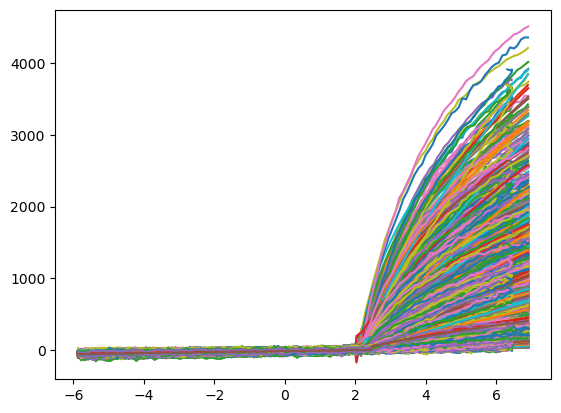

In [12]:
ne = np.array([])
Te = np.array([])
for sw in np.arange(122, 475):
    dat = pck(path, sw, 'Full')
    iv = dat.iv
    plt.plot(iv['V'], iv['I0'])
    # print(sw)
    t, fit, popt, pcov = gen_fit(iv['V'], iv['I0'])
    plt.plot(t, fit)
    ne, Te = np.append(ne, popt[4]), np.append(Te, popt[5])
# print(popt)
print(iv['I0'])

In [13]:
print(ne)

[7.87300211e+08 1.37827688e+09 6.82204660e+08 8.57139296e+08
 1.48288661e+09 1.91824628e+09 1.48482059e+09 1.14226831e+09
 1.41635037e+09 2.03175405e+09 2.12102476e+09 2.49277001e+09
 2.59973335e+09 2.47338554e+09 2.19358682e+09 3.10387715e+09
 2.33255903e+09 2.79439411e+09 2.24894182e+09 3.00169972e+09
 3.09868900e+09 2.69916945e+09 2.85100068e+09 3.61845077e+09
 3.69196197e+09 3.64867170e+09 3.91950585e+09 5.11328187e+09
 3.61116405e+09 5.04446228e+09 4.36606397e+09 4.89205063e+09
 5.96736383e+09 6.19596770e+09 5.47808633e+09 6.42206181e+09
 6.38683136e+09 6.29835389e+09 6.20120611e+09 6.90017823e+09
 7.52004631e+09 6.62692979e+09 7.46851137e+09 5.89971494e+09
 7.22566690e+09 8.90682008e+09 8.04556273e+09 5.33219043e+09
 7.44799753e+09 7.34168068e+09 1.02823584e+10 8.12498345e+09
 1.03164170e+10 7.99415179e+09 8.50129426e+09 1.04521637e+10
 6.12636290e+09 1.09406237e+10 6.16155528e+09 1.04966411e+10
 9.02815025e+09 1.18837321e+10 7.12443086e+09 8.41791377e+09
 1.07929410e+10 1.397426

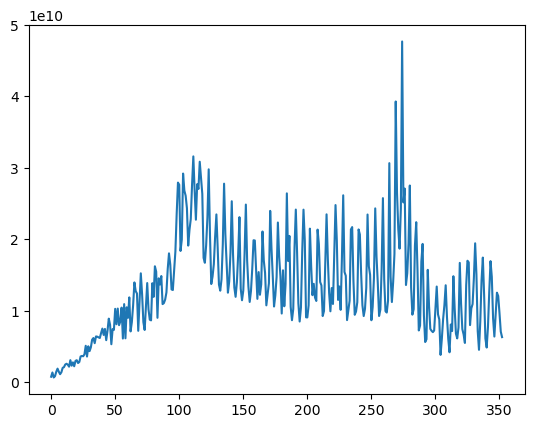

In [14]:
plt.plot(ne)

In [15]:
df = pd.DataFrame(data = {
                    'ne' : ne,
                    'Te' : Te
                        })

In [16]:
print(len(df))

353


In [17]:
df2 = df.rolling(10).mean()

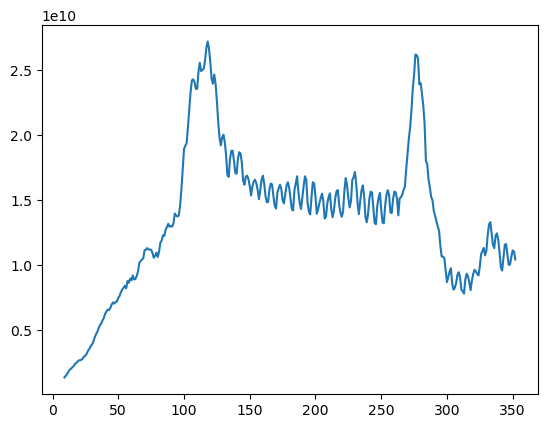

In [18]:
plt.plot(df2['ne'])

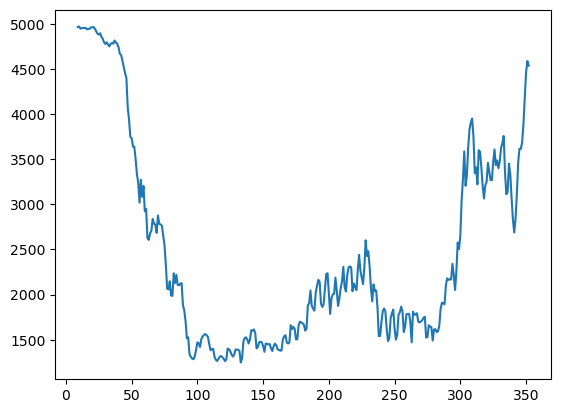

In [19]:
plt.plot(df2['Te'])